In [1]:
import tensorflow as tf
print(tf.__version__)

2.9.1


In [2]:
tf.config.list_physical_devices('GPU')

2023-09-18 08:33:39.137684: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-18 08:33:39.138012: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:03:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-18 08:33:39.145360: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-18 08:33:39.145667: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:03:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-18 08:33:39.145952: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not op

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
import os
import numpy as np

IMAGES_WITH = 128
IMAGES_HEIGHT = 128

# data from here https://www.kaggle.com/datasets/franciscoescobar/satellite-images-of-water-bodies

images_path = "./data/Water Bodies Dataset/Images"
masks_path = "./data/Water Bodies Dataset/Masks"

images = []
masks = []
for path in os.listdir(images_path):
  image = tf.io.read_file(images_path + "/" + path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, (IMAGES_HEIGHT, IMAGES_WITH), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  image = tf.math.divide(image, 255)
  images.append(image)

  mask = tf.io.read_file(masks_path + "/" + path)
  mask = tf.image.decode_jpeg(mask, channels=1)
  mask = tf.image.resize(mask, (IMAGES_HEIGHT, IMAGES_WITH), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  mask = tf.where(mask > 127, 1, 0)
  masks.append(mask)

images = np.array(images)
masks = np.array(masks)

print("dataset size")
print(images.shape)
print(masks.shape)

split = 0.8

images_train = images[:int(images.shape[0]*split)]
masks_train = masks[:int(masks.shape[0]*split)]

print("train size")
print(images_train.shape)
print(masks_train.shape)

images_val = images[int(images.shape[0]*split):]
masks_val = masks[int(masks.shape[0]*split):]

print("validation size")
print(images_val.shape)
print(masks_val.shape)

2023-09-18 08:34:02.709623: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-18 08:34:03.014370: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-18 08:34:03.014750: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:03:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-18 08:34:03.015053: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built witho

dataset size
(2841, 128, 128, 3)
(2841, 128, 128, 1)
train size
(2272, 128, 128, 3)
(2272, 128, 128, 1)
validation size
(569, 128, 128, 3)
(569, 128, 128, 1)


In [4]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):

    conv = tf.keras.layers.Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)

    conv = tf.keras.layers.Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)

    if dropout_prob > 0:
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv)
    else:
        next_layer = conv

    skip_connection = conv

    return next_layer, skip_connection

def upsampling_block(expansive_input, contractive_input, n_filters=32):

    up = tf.keras.layers.Conv2DTranspose(
                 n_filters,    # number of filters
                 3,    # Kernel size
                 strides=(2,2),
                 padding='same')(expansive_input)

    merge = tf.keras.layers.concatenate([up, contractive_input], axis=3)

    conv = tf.keras.layers.Conv2D(n_filters,   # Number of filters
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)

    conv = tf.keras.layers.Conv2D(n_filters,  # Number of filters
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)

    return conv

def unet_model(input_size=(128, 128, 3), n_filters=32):

    inputs = tf.keras.layers.Input(input_size)

    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], 2*n_filters)
    cblock3 = conv_block(cblock2[0], 2**2*n_filters)
    cblock4 = conv_block(cblock3[0], 2**3*n_filters, dropout_prob=0.3)
    cblock5 = conv_block(cblock4[0], 2**4*n_filters, dropout_prob=0.3, max_pooling=False)

    ublock6 = upsampling_block(cblock5[0], cblock4[1],  2**3*n_filters)
    ublock7 = upsampling_block(ublock6, cblock3[1],  2**2*n_filters)
    ublock8 = upsampling_block(ublock7, cblock2[1],  2*n_filters)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)

    conv9 = tf.keras.layers.Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = tf.keras.layers.Conv2D(1, 1, padding='same',activation='sigmoid')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

model = unet_model(input_size=(IMAGES_HEIGHT, IMAGES_WITH, 3), n_filters=32)

model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

In [5]:
history = model.fit(images_train, masks_train, epochs=10, validation_data=(images_val, masks_val))

Epoch 1/10


2023-09-18 08:34:59.533133: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2023-09-18 08:35:01.260230: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-09-18 08:35:01.260745: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-09-18 08:35:01.260796: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-09-18 08:35:01.261351: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-09-18 08:35:01.261446: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


71/71 [==============================] - 15s 116ms/step - loss: 0.5334 - accuracy: 0.7520 - val_loss: 0.5343 - val_accuracy: 0.7380
Epoch 2/10
71/71 [==============================] - 8s 106ms/step - loss: 0.4742 - accuracy: 0.7832 - val_loss: 0.4461 - val_accuracy: 0.7940
Epoch 3/10
71/71 [==============================] - 8s 107ms/step - loss: 0.4262 - accuracy: 0.8126 - val_loss: 0.4188 - val_accuracy: 0.8263
Epoch 4/10
71/71 [==============================] - 8s 107ms/step - loss: 0.3974 - accuracy: 0.8346 - val_loss: 0.3686 - val_accuracy: 0.8527
Epoch 5/10
71/71 [==============================] - 8s 107ms/step - loss: 0.3917 - accuracy: 0.8385 - val_loss: 0.3465 - val_accuracy: 0.8641
Epoch 6/10
71/71 [==============================] - 8s 107ms/step - loss: 0.3739 - accuracy: 0.8478 - val_loss: 0.3417 - val_accuracy: 0.8688
Epoch 7/10
71/71 [==============================] - 8s 108ms/step - loss: 0.3537 - accuracy: 0.8567 - val_loss: 0.3270 - val_accuracy: 0.8731
Epoch 8/10
71/71

1/1 [==============================] - 0s 23ms/step


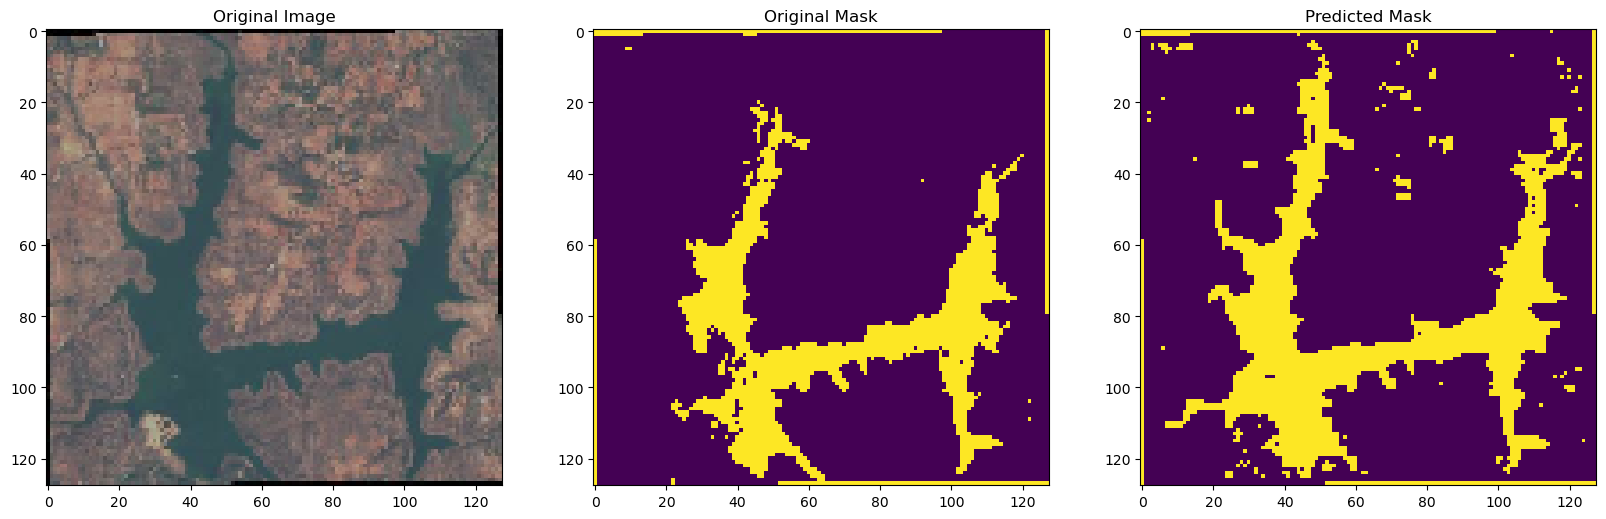

In [11]:
import random
import matplotlib.pyplot as plt

figure, axes = plt.subplots(1, 3, figsize=(20,20))

rand_num = random.randint(0, images_val.shape[0])

original_img = images_val[rand_num]
axes[0].imshow(original_img)
axes[0].title.set_text('Original Image')

original_mask = masks_val[rand_num]
axes[1].imshow(original_mask)
axes[1].title.set_text('Original Mask')

predicted_mask = model.predict(np.array([original_img]))[0]
predicted_mask = tf.where(predicted_mask > 0.5, 1, 0)
axes[2].imshow(predicted_mask)
axes[2].title.set_text('Predicted Mask')